# Pneumonia Detection with VGG16

In [ ]:
conda install tensorflow=2.10

In [1]:
#Usual imports
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
#Tensorflow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import load_img
from keras.models import load_model
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
#Displaying the image count and structure
def count_images(directory):
    return sum(1 for _ in os.listdir(directory) if _.endswith(('.png', '.jpg', '.jpeg')))

def summarize_data(base_dir):
    return {split: {category: count_images(os.path.join(base_dir, split, category)) 
                    for category in ['NORMAL', 'PNEUMONIA']} 
            for split in ['train', 'val', 'test']}

base_dir = './dataset'
data_summary = summarize_data(base_dir)

for split, categories in data_summary.items():
    print(f'{split.capitalize()} data:')
    for category, count in categories.items():
        print(f'  {category}: {count} images')
    print()

Train data:
  NORMAL: 1341 images
  PNEUMONIA: 3875 images

Val data:
  NORMAL: 8 images
  PNEUMONIA: 8 images

Test data:
  NORMAL: 234 images
  PNEUMONIA: 390 images



In [4]:
#Instantiate data generator for training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#Instantiate data generator for testing data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
#Load the training data via the training data generator
training_set = train_datagen.flow_from_directory(
    directory = './dataset/train',     # The folder which contains subfolders containing the training data.
    target_size = (224, 224),       # The size of the input images. Every image will be resized to this size.
    batch_size = 10,                # Number of images to be yielded by the generator per batch
    class_mode = 'categorical',     # The type of label arrays returned
)

#Load the testing data via the testing data generator
testing_set = test_datagen.flow_from_directory(
    directory = './dataset/test',      # The folder which contains subfolders containing the testing data.
    target_size = (224, 224),       # The size of the input images. Every image will be resized to this size.
    batch_size = 10,                # Number of images to be yielded by the generator per batch
    class_mode = 'categorical',     # The type of label arrays returned
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
#Load sub-folders containing training data
folders = glob("./dataset/train/*")
print(folders)

['./dataset/train\\NORMAL', './dataset/train\\PNEUMONIA']


In [7]:
#Load the VGG16 model
vgg = VGG16(
    input_shape=(224, 224, 3),    # Specify input image properties, i.e. 224px by 224px, 3 color channel (RGB)
    weights='imagenet',           # Load the pre-trained weights of the ImageNet dataset
    include_top=False,            # Exclude the final fully connected layer
)

In [8]:
for layer in vgg.layers:
    layer.trainable = False

In [9]:
#Instantiate flatten layer
flatten_layer=Flatten()

#Add flatten layer after VGG16's current output layer
x=(flatten_layer)(vgg.output)

In [10]:
#Instantiate dense layer
dense_layer = Dense(
    units=len(folders),     #The dimensionality of the output space (in this case, 2)
    activation="softmax",   #The activation function of the neurons in the layer
)

#Add dense layer after flatten layer to get model output
prediction = (dense_layer)(x)

In [11]:
#Instantiate model with VGG16's pre-trained layers and the custom flattened and dense layers
model = Model(inputs=vgg.input, outputs=prediction)

In [12]:
#View the structure of the combined model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
#Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
#Train the model using the augmented data
history = model.fit(
    training_set,
    validation_data=testing_set,
    epochs=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(testing_set)
)

522/522 [==============================] - 412s 788ms/step - loss: 0.2248 - accuracy: 0.9252 - val_loss: 0.5690 - val_accuracy: 0.8734


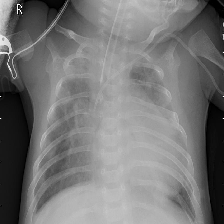

In [27]:
#Load a single image from the testing dataset
img = load_img(
    path="./dataset/test/PNEUMONIA/person1_virus_6.jpeg",
    target_size=(224, 224)
)
img

In [28]:
x=tf.keras.preprocessing.image.img_to_array(img)
x= np.expand_dims(x,axis=0,)

In [30]:
#Displaying the shape of new tensor 
print(x.shape)

(1, 224, 224, 3)


In [34]:
#Preprocess the image array as required by VGG16 from Keras Applications
img_data=preprocess_input(x)

img_data

array([[[[ -91.81701, -130.337  , -151.04001],
         [ -96.81701, -135.337  , -156.04001],
         [-100.81701, -139.337  , -160.04001],
         ...,
         [-298.81702, -337.337  , -358.04   ],
         [-298.81702, -337.337  , -358.04   ],
         [-299.81702, -338.337  , -359.04   ]],

        [[ -93.81701, -132.337  , -153.04001],
         [ -95.81701, -134.337  , -155.04001],
         [ -99.81701, -138.337  , -159.04001],
         ...,
         [-293.81702, -332.337  , -353.04   ],
         [-298.81702, -337.337  , -358.04   ],
         [-298.81702, -337.337  , -358.04   ]],

        [[ -96.81701, -135.337  , -156.04001],
         [ -95.81701, -134.337  , -155.04001],
         [-102.81701, -141.337  , -162.04001],
         ...,
         [-277.81702, -316.337  , -337.04   ],
         [-293.81702, -332.337  , -353.04   ],
         [-300.81702, -339.337  , -360.04   ]],

        ...,

        [[-288.81702, -327.337  , -348.04   ],
         [-288.81702, -327.337  , -348.04   ]

In [32]:
predictions=model.predict(img_data)

1/1 [==============================] - 1s 561ms/step


In [33]:
#Retrieve the predicted class
result=int(predictions[0][0])
if result == 0:
    print("Affected by pneumonia.")
else:
    print("Person is healthy.")

Affected by pneumonia.


In [35]:
#Saving the model
model.save('./vgg16_pneumonia_model')

INFO:tensorflow:Assets written to: ./vgg16_pneumonia_model\assets


INFO:tensorflow:Assets written to: ./vgg16_pneumonia_model\assets


In [38]:
#Saving in  hdf5 format
model.save("""./saved_models/vgg16_pneumonia_model_new.h5""")

In [39]:
#Loading the model
loaded_model = tf.keras.models.load_model("""./saved_models/vgg16_pneumonia_model_new.h5""")

In [40]:
#View Summery
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     